## Stage 1: Installing dependencies and environment setup


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 36kB/s 
     |████████████████████████████████| 4.0MB 34.4MB/s 
     |████████████████████████████████| 1.2MB 15.4MB/s 
     |████████████████████████████████| 6.0MB 28.0MB/s 
     |████████████████████████████████| 471kB 36.7MB/s 
     |████████████████████████████████| 4.0MB 28.7MB/s 
     |████████████████████████████████| 4.9MB 27.3MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installatio

In [ ]:
!pip install pandas-datareader

## Stage 2: Importing project dependencies

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
tf.__version__

'2.5.0'

## Stage 3: Building the AI Trader network

In [ ]:
# creating the class of AI trader network
class AI_Trader():
  
  def __init__(self, state_size, action_space=3, model_name="AITrader"): #action_space=Stay,Buy,sell
    
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen=2000) #deque is predefined function and stores 'maxlen' amount of elements inside it. 
    self.inventory = [] # #It holds all stock
    self.model_name = model_name
    
    #Gamma parameter helps us to maximise the current reward over long time reward

  #   """gamma is the discount factor. It quantifies how much importance we give for future rewards.
  #   It’s also handy to approximate the noise in future rewards. Gamma varies from 0 to 1. If Gamma is closer to zero, 
  #   the agent will tend to consider only immediate rewards. If Gamma is closer to one, the agent will consider future 
  #   rewards with greater weight, willing to delay the reward. """

  # """epsilon parameter is use to determine whether should we choose a random action or to use the model for it
  # epsilon parameter is set initially to 1, it means at the very beginning of training process when our network
  # is not trained at all,all actions are performed randomly."""
  # """But over time we want to decrease this number so we can stop using random action and start using mostly our train network. """
  # """Even though we have a fully trained network we still want agent to take some random action and that is
  # for our environment exploration and that's where "epsilon_final" comes into the play"""

    # when the value of epsilon is equal to or less than 0.01 we'll stop decreasin epsilon any further.

    #Epsilon decay determines how fast to decrease an epsilon.

    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
    
    self.model = self.model_builder() ##This function will create a network initialize it and store it in this self.model argument

    #  Creating brain of the program-"Neural Network"
    
  def model_builder(self):
    
    model = Sequential()

    model.add(Dense(units=32,activation='relu',input_dim = self.state_size))

    model.add(Dense(64,activation='relu'))

    model.add(Dense(128,activation='relu'))

    model.add(Dense(units=self.action_space,activation='linear'))

    model.compile(loss='mse', optimizer=Adam(lr=0.001))

    
    return model
  
  def trade(self, state):
    
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space)
    
    actions = self.model.predict(state)
    return np.argmax(actions[0])

    """trade function takes state as an input and then generates a random number.
  if that generated number is less than or equal to epsilon(note- at the very beggining it is going to bealways less than epsilon)
  this function will return totally randomly generated number between 0 to 2.
 
 If this is not the case this function will call our model and perform prediction based on the input state
 and return only the action that has the highest probability or likelyhodd between those three actions."""
  
  
  # Custom training function
  def batch_train(self, batch_size):#Function only takes batch_size as argument
    
    batch = []#selects data from expirience_replay memory
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i])

      #  """Because we are dealing with time contraint data we don't want to randomly selct 
      # samples from the memory,we'll always samle from the end of the memory, and this
      # indexing method will help us to get the exact number of points inside the batch data.
      #  Hence our 'end index' is len(self.memory)"""


       # We iterate through the batch of data and train the model for each sample from that batch
      
    for state, action, reward, next_state, done in batch: # we are iteratinng through all the information stored inside the batch of data
      reward = reward #if agent is in terminal state we'll use current reward as reward
      if not done: #making sure agent is not in terminal state
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        # if agent is not in terminal state then reward = reward + self.gamma + np.amax(self.model.predict(nex_state)[0])

      target = self.model.predict(state)
      target[0][action] = reward #modiying action with current reward

      
      self.model.fit(state, target, epochs=1, verbose=0)
      
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay #decreasing self.epsilon by mmultiplying with epsilon decay

## Stage 4: Dataset preprocessing

### Defining helper functions

#### Sigmoid

In [ ]:
# we are scaling data using sigmoid
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

#### Price format function

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n)) # if number is less than 0 meaning we loss some money, then print value with minus(-) infront upto 2 decimal points
  else:
    return "$ {0:2f}".format(abs(n))

#### Dataset loader

In [ ]:
## For demonstration
dataset = data_reader.DataReader("AAPL",data_source="yahoo")
print("dataset\n",dataset)

print("dataset.index[0]\n",dataset.index[0])

print("str(dataset.index[0]).split()[0]\n",str(dataset.index[0]).split()[0])

dataset
                   High         Low  ...       Volume   Adj Close
Date                                ...                         
2016-05-23   24.297501   23.917500  ...  152074400.0   22.520861
2016-05-24   24.522499   24.209999  ...  140560800.0   22.864182
2016-05-25   24.934999   24.527500  ...  152675200.0   23.265877
2016-05-26   25.182501   24.660000  ...  225324800.0   23.450378
2016-05-27   25.117500   24.812500  ...  145364800.0   23.436363
...                ...         ...  ...          ...         ...
2021-05-14  127.889999  125.849998  ...   81806500.0  127.449997
2021-05-17  126.930000  125.169998  ...   74244600.0  126.269997
2021-05-18  126.989998  124.779999  ...   63342900.0  124.849998
2021-05-19  124.919998  122.860001  ...   92612000.0  124.690002
2021-05-20  127.720001  125.099998  ...   76756000.0  127.309998

[1258 rows x 6 columns]
dataset.index[0]
 2016-05-23 00:00:00
str(dataset.index[0]).split()[0]
 2016-05-23


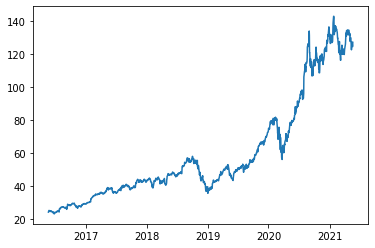

In [ ]:
plt.plot(dataset['Close'])

In [ ]:
def dataset_loader(stock_name):
  
  #Complete the dataset loader function
  dataset = data_reader.DataReader(stock_name, data_source="yahoo")
  
  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[-1]).split()[0]
  
  close = dataset['Close']

  return close

### State creator

In [ ]:
def state_creator(data, timestep, window_size):
   #data = stock, timmestep = day in which we want to predict, window_size = previous x days
   # timestep represents how many sample we have. 1 timestep is 1 day
  
  starting_id = timestep - window_size + 1

  #starting_id is new starting date of our state
  """For example when timstep is zero or our agent is just starting and window_size is 10
  the starting_id is -9, THis +1 is added because the way we create our states. We don't want prices
  on certain days but difference between current price and previous price, to see that change
  between dates we add +1 """
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])

    """ if starting id is ngetive, we'll append the day info as many times as we need to match the window_size of the data.
  minus(-) before starting id because starting_id here  is negetive multiplying by data[0] because it'll replicate it's memeber many times """
  
  state = []
  for i in range(window_size - 1): ##-1 here because we have difference between current element and one after
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i])) #normalising
    
  return np.array([state])

### Loading a dataset

In [ ]:
stock_name = "AAPL"
data = dataset_loader(stock_name)

## Stage 5: Training the AI Trader

### Setting hyper parameters

In [ ]:
window_size = 10 # 10 previous day to predict current data
episodes = 1000 #Epochs is used in supervised and we use episodes in reinforcement. how many times are we going to run in current environment

batch_size = 32
data_samples = len(data) - 1 #sinnce we are trying to predict the next day we can't use the last one.

### Defining the Trader model

In [ ]:
trader = AI_Trader(window_size) ## here window_size is parameter of state_size, meaning state_size=window_size

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
trader.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 11,171
Trainable params: 11,171
Non-trainable params: 0
_________________________________________________________________


### Training loop

In [ ]:
for episode in range(1, episodes + 1):
  
  print("Episode: {}/{}".format(episode, episodes))
  
  state = state_creator(data, 0, window_size + 1)
  
  total_profit = 0
  trader.inventory = [] # inventory stores all the stocks we bought
  
  for t in tqdm(range(data_samples)):
    
    action = trader.trade(state) #At the very beggining this actions are going to be totally randomly selected after some time
      #when the model is trained enough,it is going to take action by itself.
    
    next_state = state_creator(data, t+1, window_size + 1) # t+1 because we want the next state and not the current one
    reward = 0 #because we haven't yet bought anything in this state
    
    if action == 1: #Buying
      trader.inventory.append(data[t]) #we want the current data information to  be bought stock
      print("AI Trader bought: ", stocks_price_format(data[t]))
      
    elif action == 2 and len(trader.inventory) > 0: #Selling
      buy_price = trader.inventory.pop(0) # by this we are selling stock stocks in order
      
      reward = max(data[t] - buy_price, 0) # data[t] is current data of pur stock.
        # this means if data[T] is less than buy price,we lost the money and reward here is 0.
      total_profit += data[t] - buy_price
      # total profit is increase here with the difference between the current price and the buy price
      print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )

      #checking if this is last sample of our dataset and if that's the case we are done

      
    if t == data_samples - 1:
      done = True
    else:
      done = False

    #The next thing to do is to append all the data to our trader memory or expirience replay buffer
      
    trader.memory.append((state, action, reward, next_state, done))
    
    # we are going to change the state to our next state so we cann iterate through the whole thing
    state = next_state
    
    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    
    # check if we have more information in ourr memory of our batch_size
    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)
      
      #Checking if number of episodes in a total division of 10 is eqaul to zero. If so save the model
  if episode % 10 == 0:
    trader.model.save("ai_trader_{}.h5".format(episode))
    



  2%|▏         | 23/1257 [01:38<1:27:30,  4.26s/it]

AI Trader bought:  $ 23.350000




  2%|▏         | 24/1257 [01:42<1:27:04,  4.24s/it]

AI Trader bought:  $ 23.010000




  2%|▏         | 25/1257 [01:46<1:27:51,  4.28s/it]Exception ignored in: <function ScopedTFFunction.__del__ at 0x7fab21c559e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/c_api_util.py", line 110, in __del__
    self.deleter(self.func)
KeyboardInterrupt


AI Trader bought:  $ 23.397499




  2%|▏         | 26/1257 [01:51<1:28:47,  4.33s/it]

AI Trader bought:  $ 23.600000




  2%|▏         | 27/1257 [01:55<1:28:38,  4.32s/it]

AI Trader bought:  $ 23.900000




  2%|▏         | 28/1257 [01:59<1:28:14,  4.31s/it]

AI Trader bought:  $ 23.972500




  2%|▏         | 29/1257 [02:03<1:28:00,  4.30s/it]

AI Trader bought:  $ 23.747499




  2%|▏         | 30/1257 [02:08<1:27:14,  4.27s/it]

AI Trader bought:  $ 23.882500


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download("ai_trader_29.h5")

FileNotFoundError: ignored